<a href="https://colab.research.google.com/github/GermanOmar/SLM-ML/blob/master/ML_SLM_CV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative evaluation of supervised machine learning algorithms in the prediction of the relative density of 316L stainless steel fabricated by selective laser melting


In [96]:
!pip install -q "tqdm>=4.36.1"
!pip install -U tensorflow-addons

Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.6/dist-packages (0.11.2)


Libraries

In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import tensorflow_addons as tfa
from sklearn.inspection import permutation_importance

 Upload database:

In [98]:
#Dataset
data = pd.read_table('dataf.txt')

print("P: Laser power (W)")
print("V: Scanning speed (mm/s)")
print("L: Layer thickness (mm)")
print("H: Hatch spacing (mm) ")
print("PS: Particle size (um)")
print("RD: Relative density (%)")

data.describe()



P: Laser power (W)
V: Scanning speed (mm/s)
L: Layer thickness (mm)
H: Hatch spacing (mm) 
PS: Particle size (um)
RD: Relative density (%)


,P,V,L,H,PS,RD
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000
mean,152.142857,702.048571,0.061071,0.085536,34.792857,97.714107
std,55.369276,470.429449,0.103082,0.029617,5.190024,1.837672
min,70.000000,18.760000,0.020000,0.020000,16.000000,91.200000
25%,100.000000,250.000000,0.020000,0.060000,30.000000,97.000000
50%,150.000000,700.000000,0.030000,0.080000,35.000000,98.350000
75%,200.000000,1000.000000,0.050000,0.110000,38.000000,98.922500
max,300.000000,2000.000000,0.460000,0.150000,48.000000,99.900000


Setting inputs - output:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()


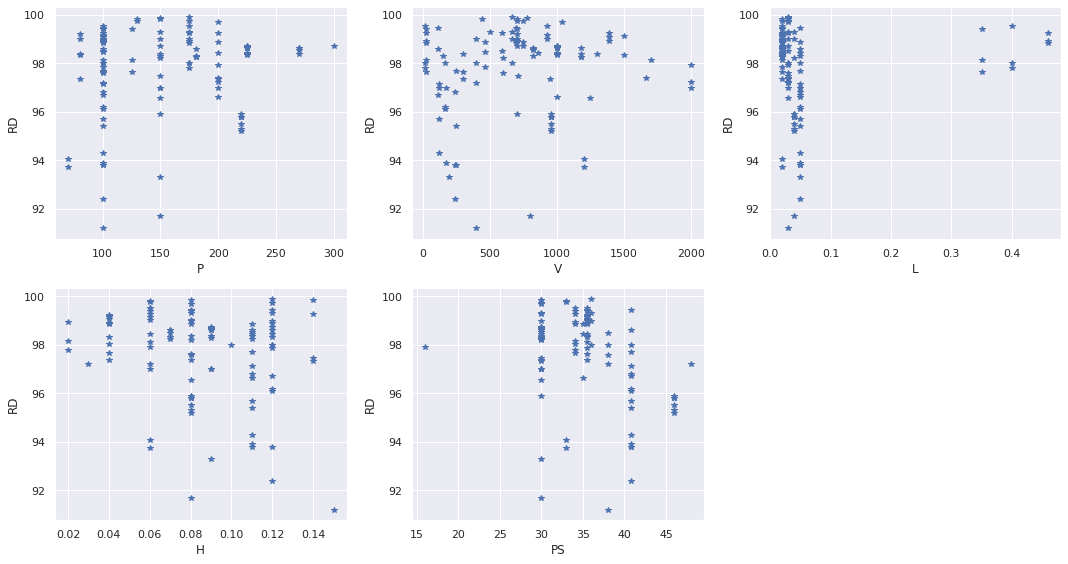

In [99]:
fields = ['P', 'V','L','H','PS']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((15,8))
for i, field in enumerate(fields):
  plt.subplot(2, 3, i + 1)
  plt.plot(data[field], data['RD'], 'b*')
  plt.xlabel(field)
  plt.ylabel('RD')

plt.tight_layout()

X=data[['P', 'V','L','H','PS']]
Y=data['RD'][:,None]


 Normalize


In [100]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [172]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xn, Yn, test_size=0.2, random_state=2)        
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17, random_state=0)
#print('training samples:', X_train.shape[0], ' validation samples:', X_val.shape[0],  ' test samples:', X_test.shape[0])
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 89  test samples: 23


# Evaluation metrics:
Coefficient of determination (R^2)
$$ R^2  = 1- \frac{\sum_{i}(y_i - y_i^*)^2}{\sum_{i} (y_i - y_i^-)^2}$$

Root mean square error (RMSE)
$$ RMSE  = \sqrt{ \frac{1}{N} \sum_{i}^N(y_i - y_i^*)^2} $$

Mean absolute error (MAE)
$$ MAE  =  \frac{1}{N} \sum_{i}^N |y_i - y_i^*|$$

https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b



## 1.-Support vector regression

In [173]:
from sklearn.svm import SVR
#KERNEL
#model4=SVR()
model1=SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.01, coef0=1)

#START TRAINING
model1.fit(X_train,y_train)

#Testing
y_star_train = model1.predict(X_train)
y_pred = model1.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("-Support vector regression-")
print("---------------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score as CV
scores = CV(model1, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(-1*scores)
print("CV-MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), -1*scores.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-Support vector regression-
---------------------------
MSE train: 0.34844803501356975
MSE test: 0.3896456481566911
MSE train < MSE test? True

[ 2.44130586  1.13352978  0.84181298  1.40496982 29.19225758]
CV-MSE: 7.00 (+/- -22.22)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 2.-Decision tree regressor

In [174]:
from sklearn.tree import DecisionTreeRegressor
model2=DecisionTreeRegressor(max_depth=8)

#START TRAINING
model2.fit(X_train,y_train)

#Testing
y_star_train = model2.predict(X_train)
y_pred = model2.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("-Decision tree regressor-")
print("-------------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score as CV
scores = CV(model2, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(-1*scores)
print("CV-MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), -1*scores.std() * 2))

-Decision tree regressor-
-------------------------
MSE train: 0.05034632249162991
MSE test: 0.6343711271529523
MSE train < MSE test? True

[0.63684384 0.54302375 0.82315559 1.70825538 0.54262031]
CV-MSE: 0.85 (+/- -0.88)


## 3.-Random forest regressor

In [175]:
from sklearn.ensemble import RandomForestRegressor
#KERNEL
model3=RandomForestRegressor(n_estimators=100,max_depth=20)

#TRAINING
model3.fit(X_train,y_train)

#Testing
y_star_train = model3.predict(X_train)
y_pred = model3.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("-Random forest regressor-")
print("-------------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score as CV
scores = CV(model3, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(-1*scores)
print("CV-MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), -1*scores.std() * 2))

-Random forest regressor-
-------------------------
MSE train: 0.1121810942941389
MSE test: 0.4429190981907688
MSE train < MSE test? True



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

[0.56280498 0.60994608 0.66008766 1.73243842 0.32827429]
CV-MSE: 0.78 (+/- -0.98)


## 4.-Gradient boosting regressor



In [176]:
from sklearn.ensemble import GradientBoostingRegressor
#HYPERPARAMETERS
params = {'n_estimators': 2000, 'max_depth': 20, 'min_samples_split': 5, 'max_leaf_nodes': 10,
          'learning_rate': 0.001, 'random_state': 1234,'loss': 'ls'}
#KERNEL
model4 = GradientBoostingRegressor(**params)
#TRAIN
model4.fit(X_train,y_train)

#TESTING
y_star_train = model4.predict(X_train)
#y_star_val = model1.predict(X_val)
y_pred = model4.predict(X_test)

from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)
MSE_train = MSE(y_train, y_star_train)
 
print("-Gradient boosting regressor-")
print("-----------------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score as CV
scores = CV(model4, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(-1*scores)
print("CV-MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), -1*scores.std() * 2))


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-Gradient boosting regressor-
-----------------------------
MSE train: 0.16842688616001011
MSE test: 0.3840114411920342
MSE train < MSE test? True



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

[0.51159805 0.71898634 0.6669073  1.74129834 0.25420059]
CV-MSE: 0.78 (+/- -1.02)


##5.-Gaussian Process

In [177]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
model5=GPR(kernel=kernel, n_restarts_optimizer=10, alpha=0.001, normalize_y=True)
 
#Training
model5.fit(X_train,y_train)
 
#Testing
y_star_train = model5.predict(X_train)
y_pred = model5.predict(X_test)
  
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("-Gaussian Process-")
print("------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score as CV
scores = CV(model5, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(-1*scores)
print("CV-MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), -1*scores.std() * 2))


-Gaussian Process-
------------------
MSE train: 0.03436789695043825
MSE test: 0.6206672436661015
MSE train < MSE test? True

[0.40176166 0.79207664 0.92217813 1.68736198 0.31687401]
CV-MSE: 0.82 (+/- -0.98)


## 6.- K-Nearest Neighbors


In [178]:
from sklearn.neighbors import KNeighborsRegressor
#KERNEL
model6 = KNeighborsRegressor(n_neighbors=3)

#START TRAINING
model6.fit(X_train,y_train)

#Testing
y_star_train = model6.predict(X_train)
y_pred = model6.predict(X_test)
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("-K-Nearest Neighbors-")
print("---------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score as CV
scores = CV(model6, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(-1*scores)
print("CV-MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), -1*scores.std() * 2))

-K-Nearest Neighbors-
---------------------
MSE train: 0.3966161064100466
MSE test: 0.5358545401732014
MSE train < MSE test? True

[0.72422015 0.75981488 0.63371863 1.77933246 0.14076244]
CV-MSE: 0.81 (+/- -1.07)


## 7.-Deep Neural Networks

In [179]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

In [180]:
width = 10
depth = 5
L2 = 0.001

net_input = Input(shape=(Xn.shape[1],),name='input')

net_output = Sequential([Dense(width, 'relu', kernel_regularizer=regularizers.l2(L2))]*(depth - 1) + [Dense(1, 'linear', kernel_regularizer=regularizers.l2(L2))], name = 'base_NN')(net_input) 

model = Model(inputs=net_input, outputs=net_output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [181]:
history = model.fit(X_train, y_train, epochs=3000, validation_data= (X_test, y_test), batch_size = 10,  verbose = 3)

Epoch 1/3000
Epoch 2/3000
Epoch 3/3000
Epoch 4/3000
Epoch 5/3000
Epoch 6/3000
Epoch 7/3000
Epoch 8/3000
Epoch 9/3000
Epoch 10/3000
Epoch 11/3000
Epoch 12/3000
Epoch 13/3000
Epoch 14/3000
Epoch 15/3000
Epoch 16/3000
Epoch 17/3000
Epoch 18/3000
Epoch 19/3000
Epoch 20/3000
Epoch 21/3000
Epoch 22/3000
Epoch 23/3000
Epoch 24/3000
Epoch 25/3000
Epoch 26/3000
Epoch 27/3000
Epoch 28/3000
Epoch 29/3000
Epoch 30/3000
Epoch 31/3000
Epoch 32/3000
Epoch 33/3000
Epoch 34/3000
Epoch 35/3000
Epoch 36/3000
Epoch 37/3000
Epoch 38/3000
Epoch 39/3000
Epoch 40/3000
Epoch 41/3000
Epoch 42/3000
Epoch 43/3000
Epoch 44/3000
Epoch 45/3000
Epoch 46/3000
Epoch 47/3000
Epoch 48/3000
Epoch 49/3000
Epoch 50/3000
Epoch 51/3000
Epoch 52/3000
Epoch 53/3000
Epoch 54/3000
Epoch 55/3000
Epoch 56/3000
Epoch 57/3000
Epoch 58/3000
Epoch 59/3000
Epoch 60/3000
Epoch 61/3000
Epoch 62/3000
Epoch 63/3000
Epoch 64/3000
Epoch 65/3000
Epoch 66/3000
Epoch 67/3000
Epoch 68/3000
Epoch 69/3000
Epoch 70/3000
Epoch 71/3000
Epoch 72/3000
E

-Deep Neural Networks-
----------------------
MSE train: 0.32414937222987317
MSE test: 0.4970231459505447
MSE train < MSE test? True



'\nscores = CV(model, X_train, y_train, cv=5, scoring=\'neg_mean_squared_error\')\nprint(-1*scores)\nprint("CV-MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), -1*scores.std() * 2))\n'

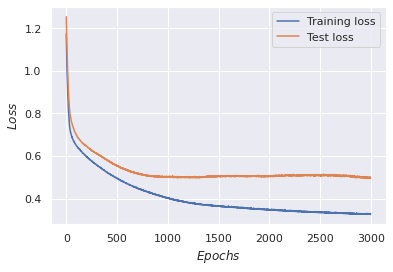

In [182]:
plt.plot(history.history['mean_squared_error'], label = 'Training loss')
plt.plot(history.history['val_mean_squared_error'], label = 'Test loss')
#plt.yscale('log')
plt.legend()
plt.ylabel('$Loss$')
plt.xlabel('$Epochs$')

#TESTING
y_star_train = model.predict(X_train)
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)

 
print("-Deep Neural Networks-")
print("----------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

"""
scores = CV(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(-1*scores)
print("CV-MSE: %0.2f (+/- %0.2f)" % (-1*scores.mean(), -1*scores.std() * 2))
"""

#Comparison:

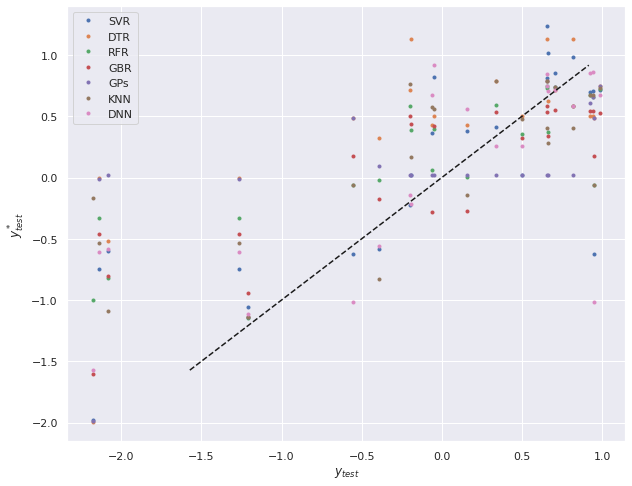

In [183]:
models = [model1, model2, model3, model4, model5, model6, model]
labels = ['SVR', 'DTR', 'RFR', 'GBR', 'GPs', 'KNN', 'DNN']

fig = plt.figure()
fig.set_size_inches((10,8))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, '.' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()  
  
  

In [184]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 

models = [model1, model2, model3, model4, model5, model6, model]
labels = ['SVR', 'DTR', 'RFR', 'GBR', 'GPs', 'KNN', 'DNN']
IMS = []

print("--------------------------------------------------------------")
print("%15s | %6s | %6s | %6s | %5s" % ("ML algorithm", "R2" , "RMSE", "MAE", "Index of merit"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  R2=r2_score(y_test, y_pred)
  RMSE = np.square(MSE(y_test, y_pred))
  MAE = mean_absolute_error(y_test, y_pred)
  IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
 
  print("%15s | %.4f | %.4f | %.4f | %.4f" % (label, R2, RMSE, MAE, IM))
print("--------------------------------------------------------------")
  

--------------------------------------------------------------
   ML algorithm |     R2 |   RMSE |    MAE | Index of merit
--------------------------------------------------------------
            SVR | 0.6198 | 0.1518 | 0.4353 | 0.5976
            DTR | 0.3810 | 0.4024 | 0.5868 | 0.9431
            RFR | 0.5678 | 0.1962 | 0.4831 | 0.6772
            GBR | 0.6253 | 0.1475 | 0.4922 | 0.6360
            GPs | 0.3944 | 0.3852 | 0.5365 | 0.8961
            KNN | 0.4771 | 0.2871 | 0.5514 | 0.8123
            DNN | 0.5150 | 0.2470 | 0.4574 | 0.7110
--------------------------------------------------------------


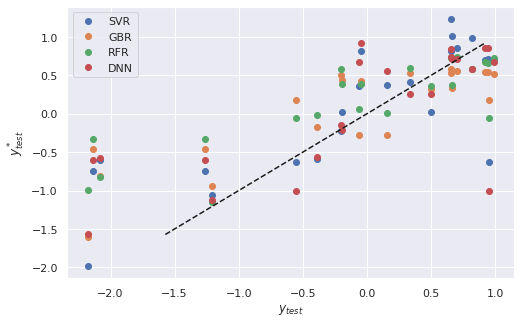

In [187]:
#BEST MODELS:
models = [model1, model4, model3,  model]
labels = ['SVR', 'GBR', 'RFR',  'DNN']

fig = plt.figure()
fig.set_size_inches((8,5))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()  
  
  